In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile

In [2]:
star = lk.search_lightcurve('TOI 2263.01',exptime=120)
star

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,159400561,0.0
1,TESS Sector 19,2019,SPOC,120,159400561,0.0
2,TESS Sector 20,2019,SPOC,120,159400561,0.0
3,TESS Sector 21,2020,SPOC,120,159400561,0.0
4,TESS Sector 25,2020,SPOC,120,159400561,0.0
5,TESS Sector 26,2020,SPOC,120,159400561,0.0
6,TESS Sector 40,2021,SPOC,120,159400561,0.0
7,TESS Sector 41,2021,SPOC,120,159400561,0.0
8,TESS Sector 47,2021,SPOC,120,159400561,0.0


In [3]:
lc = star.download_all()
#lc

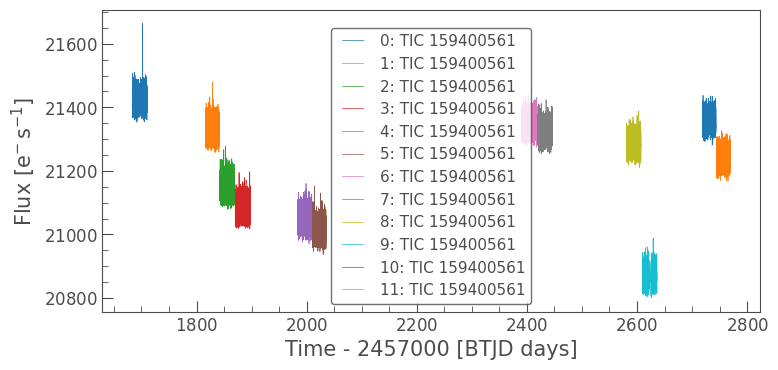

In [4]:
lc.plot();

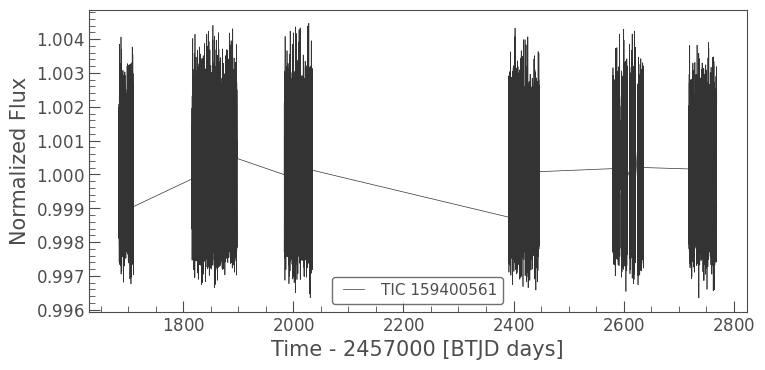

In [5]:
# Flatten the light curve
lc_flat = lc.stitch().flatten(window_length=1001).remove_outliers()
lc_flat.plot();

(2760.0, 2769.0)

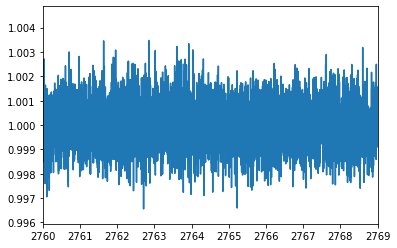

In [9]:
plt.plot(lc_flat.time.btjd,lc_flat.flux)
#plt.xlim(1755,1756)
plt.xlim(2760,2769)

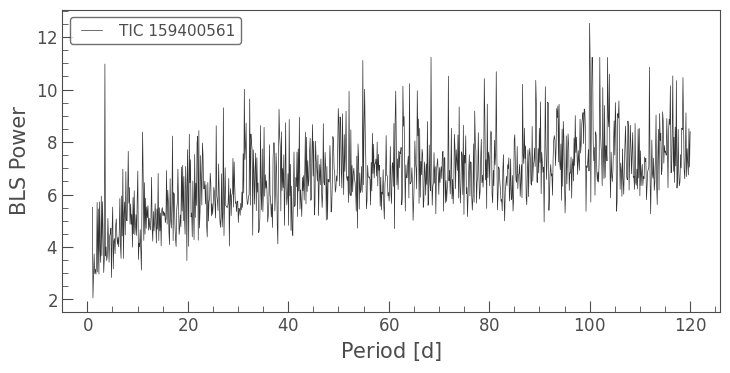

In [21]:
# Create array of periods to search
period = np.linspace(1, 120, 1000)
# Create a BLSPeriodogram
bls = lc_flat.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [22]:
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power

# Check the value for period
planet_period

<Quantity 99.98798799 d>

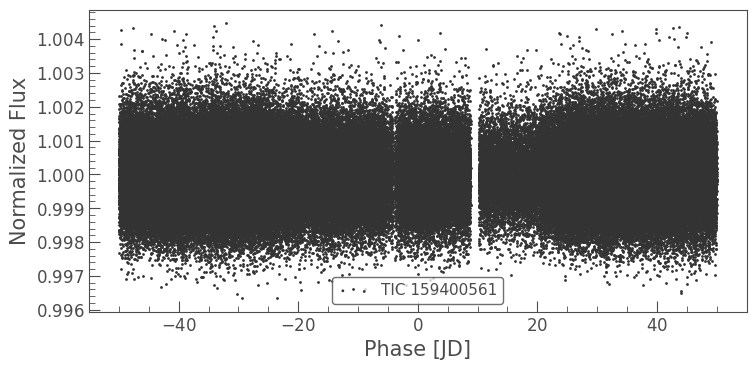

In [24]:
ax = lc_flat.fold(period=planet_period, epoch_time=planet_t0).scatter()
#ax.set_xlim(-1, 1);

In [25]:
# Create a cadence mask using the BLS parameters
planet_mask = bls.get_transit_mask(period=planet_period,
                                     transit_time=planet_t0,
                                     duration=planet_dur)

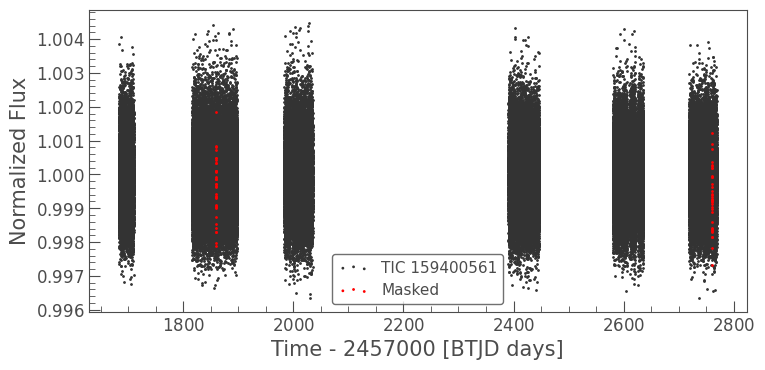

In [26]:
masked_lc = lc_flat[~planet_mask]
ax = masked_lc.scatter();
lc_flat[planet_mask].scatter(ax=ax, c='r', label='Masked');

In [27]:
# Create a BLS model using the BLS parameters
planet_model = bls.get_transit_model(period=planet_period,
                                       transit_time=planet_t0,
                                       duration=planet_dur)

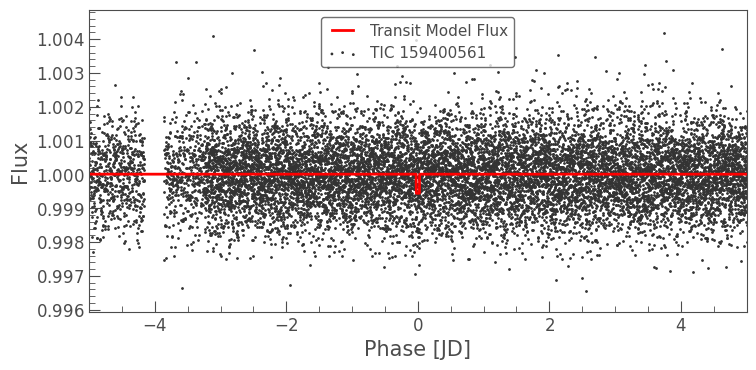

In [28]:
ax = lc_flat.fold(planet_period, planet_t0).scatter()
planet_model.fold(planet_period, planet_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5);

In [29]:
lc_flat.interact_bls()

Extra planet signals?

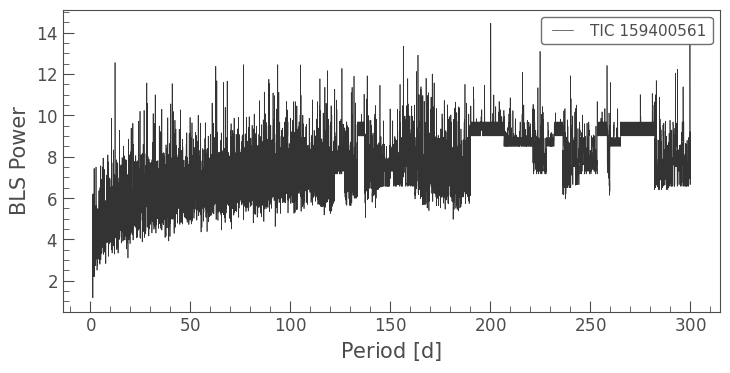

In [30]:
period2 = np.linspace(1, 300, 10000)
bls2 = masked_lc.to_periodogram('bls', period=period2, frequency_factor=500)
bls2.plot();

In [31]:
planet_c_period = bls2.period_at_max_power
planet_c_t0 = bls2.transit_time_at_max_power
planet_c_dur = bls2.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 200.21372137 d>

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

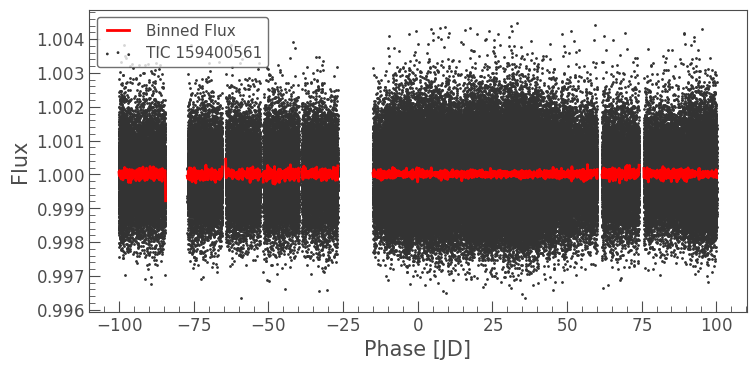

In [32]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
#ax.set_xlim(-5, 5);